In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from func import *
from diffusion_func import *

In [3]:
# load data

exper_name = "promoter_1"

seq = np.load("data/{}.npy".format(exper_name), allow_pickle=True)

seq_list = seq.tolist()

seq_len = len(seq_list[0])

print(seq_len)
level_list = [x for x in range(seq.size)]
seq_dict = {'seq': seq_list, 'name': level_list}
data = pd.DataFrame(seq_dict)

save_fasta(data)

nucleotides = ['A', 'C', 'T', 'G']

dna_alphabet = ['A', 'C', 'T', 'G']
#
# nucleotides = ['a', 'c', 't', 'g']
#
# dna_alphabet = ['a', 'c', 't', 'g']

# one_hot code
x_train_seq = np.array(
    [one_hot_encode(x, dna_alphabet, seq_len) for x in tqdm_notebook(data['seq']) if 'N' not in x]
)

X_train = x_train_seq
X_train = np.array([x.T.tolist() for x in X_train])
# inplace 0 to -1
X_train[X_train == 0] = -1

tf = T.Compose([T.ToTensor()])
batch_size = 64
# dataset
seq_dataset = SequenceDataset(seqs=X_train, transform=tf)
# item shape(64, 1, 4, 60)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=False)


52


C:\Users\lin\AppData\Local\Temp\ipykernel_29548\3753093404.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, dna_alphabet, seq_len) for x in tqdm_notebook(data['seq']) if 'N' not in x]


  0%|          | 0/11884 [00:00<?, ?it/s]

In [4]:
# noise timestep
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps, beta_end=0.05)

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
# pad
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

epochs = 130
save_and_sample_every = 10
epochs_loss_show = 1

print(device)
image_size = seq_len
channels = 1

model = Unet(dim=60, channels=1, dim_mults=(1, 2, 4), resnet_block_groups=1).cuda()

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

cuda
60 init_dim
Conv2d(2, 60, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
final 60 1 Conv2d(60, 1, kernel_size=(1, 1), stride=(1, 1))


In [7]:
for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_dl):

        x = batch
        x = x.type(torch.float32).to(device)
        optimizer.zero_grad()
        # print (batch[0].dtype)
        # batch_size=64
        batch_size = x.shape[0]
        # batch_size = batch["pixel_values"].shape[0]
        # batch = batch["pixel_values"].to(device)
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()  # sampling a t to generate t and t+1
        # print (t.dtype)
        # loss = p_losses(model, batch, t, loss_type="l2")

        loss = p_losses(denoise_model=model, x_start=x, t=t,
                        sqrt_alphas_cumprod=sqrt_alphas_cumprod,
                        sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                        loss_type="huber")
        loss.backward()
        optimizer.step()

    if (epoch % epochs_loss_show) == 0:
        print(f" Epoch {epoch} Loss:", loss.item())

    torch.save(model.state_dict(), "model/{}/model_epoch_{}.pth".format(exper_name, epoch))

    # save generated images
    if epoch != 0 and epoch % save_and_sample_every == 0:
        print('saving')
        # sample(model, image_size, batch_size=16, channels=3)
        milestone = step // save_and_sample_every
        samples = sample(model, image_size=image_size, batch_size=2, channels=1, timesteps=timesteps, betas=betas,                         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                         sqrt_recip_alphas=sqrt_recip_alphas,
                         posterior_variance=posterior_variance)
        n_print = 0
        # for image in samples[-1]:
        #     if n_print < 4:
        #         plt.rcParams["figure.figsize"] = (12, 1)
        #         pd_seq = pd.DataFrame(image.reshape(4, seq_len))
        #         pd_seq.index = nucleotides
        #         sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        #         plt.show()
        #         plt.rcParams["figure.figsize"] = (2, 2)
        #         plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
        #         plt.show()
        #         n_print = n_print + 1

  0%|          | 0/130 [00:00<?, ?it/s]

 Epoch 0 Loss: 0.0954311415553093
 Epoch 1 Loss: 0.0509038008749485
 Epoch 2 Loss: 0.04660350829362869
 Epoch 3 Loss: 0.034803688526153564
 Epoch 4 Loss: 0.05959750711917877
 Epoch 5 Loss: 0.04309960827231407
 Epoch 6 Loss: 0.045808445662260056
 Epoch 7 Loss: 0.033393654972314835
 Epoch 8 Loss: 0.02709243632853031
 Epoch 9 Loss: 0.036482591181993484
 Epoch 10 Loss: 0.041940540075302124
saving
 Epoch 11 Loss: 0.04875972494482994
 Epoch 12 Loss: 0.03155302256345749
 Epoch 13 Loss: 0.04192911088466644
 Epoch 14 Loss: 0.03329838067293167
 Epoch 15 Loss: 0.02950202487409115
 Epoch 16 Loss: 0.03854399919509888
 Epoch 17 Loss: 0.03305523470044136
 Epoch 18 Loss: 0.02889166586101055
 Epoch 19 Loss: 0.04316841810941696
 Epoch 20 Loss: 0.03316475450992584
saving
 Epoch 21 Loss: 0.034592404961586
 Epoch 22 Loss: 0.02619888447225094
 Epoch 23 Loss: 0.03171013668179512
 Epoch 24 Loss: 0.03461485356092453
 Epoch 25 Loss: 0.03423542156815529
 Epoch 26 Loss: 0.04015837237238884
 Epoch 27 Loss: 0.02120

In [8]:
# load data

exper_name = "promoter_2"

seq = np.load("data/{}.npy".format(exper_name), allow_pickle=True)

seq_list = seq.tolist()

seq_len = len(seq_list[0])

print(seq_len)
level_list = [x for x in range(seq.size)]
seq_dict = {'seq': seq_list, 'name': level_list}
data = pd.DataFrame(seq_dict)

save_fasta(data)

nucleotides = ['A', 'C', 'T', 'G']

dna_alphabet = ['A', 'C', 'T', 'G']
#
# nucleotides = ['a', 'c', 't', 'g']
#
# dna_alphabet = ['a', 'c', 't', 'g']

# one_hot code
x_train_seq = np.array(
    [one_hot_encode(x, dna_alphabet, seq_len) for x in tqdm_notebook(data['seq']) if 'N' not in x]
)

X_train = x_train_seq
X_train = np.array([x.T.tolist() for x in X_train])
# inplace 0 to -1
X_train[X_train == 0] = -1

tf = T.Compose([T.ToTensor()])
batch_size = 64
# dataset
seq_dataset = SequenceDataset(seqs=X_train, transform=tf)
# item shape(64, 1, 4, 60)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=False)


168


C:\Users\lin\AppData\Local\Temp\ipykernel_170500\528475597.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, dna_alphabet, seq_len) for x in tqdm_notebook(data['seq']) if 'N' not in x]


  0%|          | 0/11592 [00:00<?, ?it/s]

In [9]:
# noise timestep
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps, beta_end=0.05)

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
# pad
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


In [10]:
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

epochs = 120
save_and_sample_every = 10
epochs_loss_show = 1

print(device)
image_size = seq_len
channels = 1

model = Unet(dim=60, channels=1, dim_mults=(1, 2, 4), resnet_block_groups=1).cuda()

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

cuda
60 init_dim
Conv2d(2, 60, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
final 60 1 Conv2d(60, 1, kernel_size=(1, 1), stride=(1, 1))


  0%|          | 0/120 [00:00<?, ?it/s]

 Epoch 0 Loss: 0.04597030580043793
 Epoch 1 Loss: 0.04127802699804306
 Epoch 2 Loss: 0.029812492430210114
 Epoch 3 Loss: 0.060229942202568054
 Epoch 4 Loss: 0.039868634194135666
 Epoch 5 Loss: 0.07821723818778992
 Epoch 6 Loss: 0.05688556656241417
 Epoch 7 Loss: 0.03140190616250038
 Epoch 8 Loss: 0.04633419215679169
 Epoch 9 Loss: 0.01637902483344078
 Epoch 10 Loss: 0.033840619027614594
saving


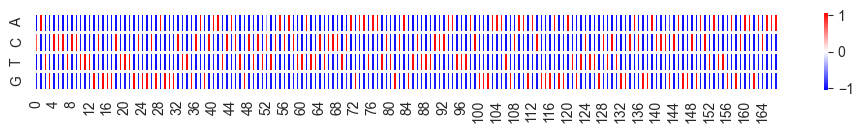

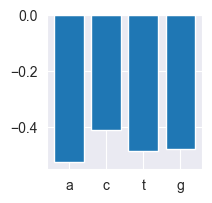

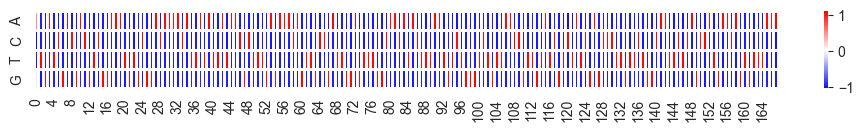

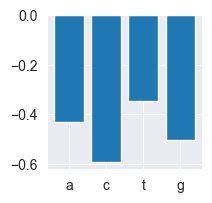

 Epoch 11 Loss: 0.025761282071471214
 Epoch 12 Loss: 0.02552442066371441
 Epoch 13 Loss: 0.019130172207951546
 Epoch 14 Loss: 0.06382298469543457
 Epoch 15 Loss: 0.027590185403823853
 Epoch 16 Loss: 0.027574222534894943
 Epoch 17 Loss: 0.038748037070035934
 Epoch 18 Loss: 0.04114071652293205
 Epoch 19 Loss: 0.04063574969768524
 Epoch 20 Loss: 0.026521915569901466
saving


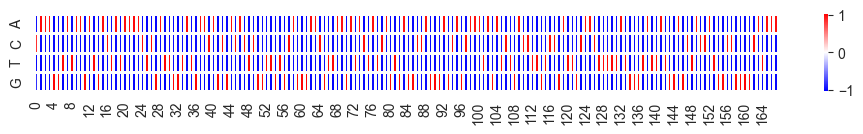

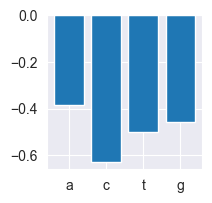

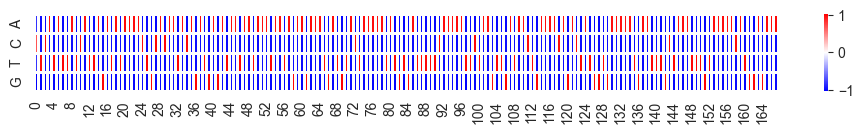

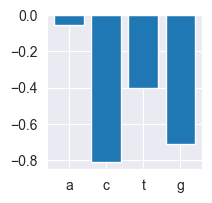

 Epoch 21 Loss: 0.030056249350309372
 Epoch 22 Loss: 0.039724912494421005
 Epoch 23 Loss: 0.02166772447526455
 Epoch 24 Loss: 0.03609325736761093
 Epoch 25 Loss: 0.03558453544974327
 Epoch 26 Loss: 0.022319938987493515
 Epoch 27 Loss: 0.02004641853272915
 Epoch 28 Loss: 0.020049674436450005
 Epoch 29 Loss: 0.028739798814058304
 Epoch 30 Loss: 0.013134482316672802
saving


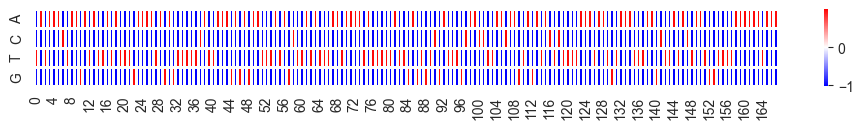

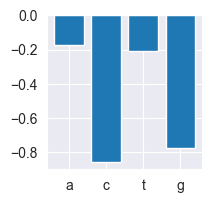

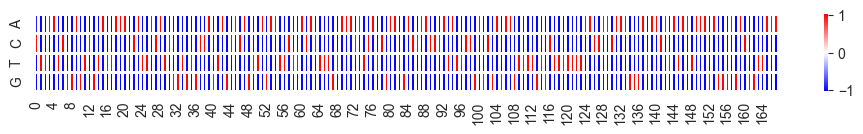

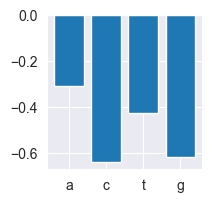

 Epoch 31 Loss: 0.03147321194410324
 Epoch 32 Loss: 0.009470692835748196
 Epoch 33 Loss: 0.006144041195511818
 Epoch 34 Loss: 0.028976332396268845
 Epoch 35 Loss: 0.020056596025824547
 Epoch 36 Loss: 0.03330688923597336
 Epoch 37 Loss: 0.021361736580729485
 Epoch 38 Loss: 0.009934510104358196
 Epoch 39 Loss: 0.031252458691596985
 Epoch 40 Loss: 0.012628267519176006
saving


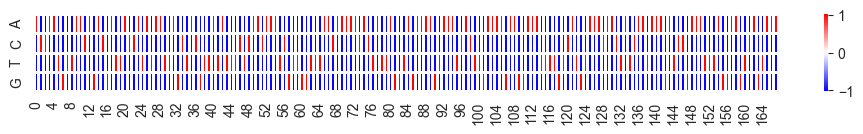

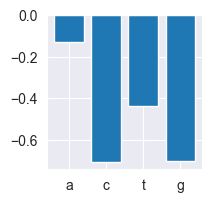

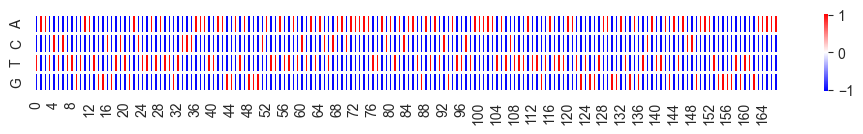

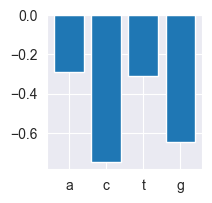

 Epoch 41 Loss: 0.055647943168878555
 Epoch 42 Loss: 0.03170214220881462
 Epoch 43 Loss: 0.046896159648895264
 Epoch 44 Loss: 0.036433782428503036
 Epoch 45 Loss: 0.032839033752679825
 Epoch 46 Loss: 0.0441494844853878
 Epoch 47 Loss: 0.015510519966483116
 Epoch 48 Loss: 0.039523109793663025
 Epoch 49 Loss: 0.015133894979953766
 Epoch 50 Loss: 0.02534995786845684
saving


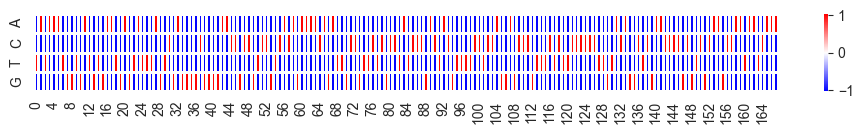

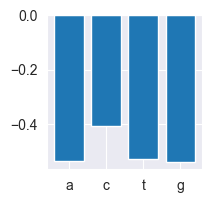

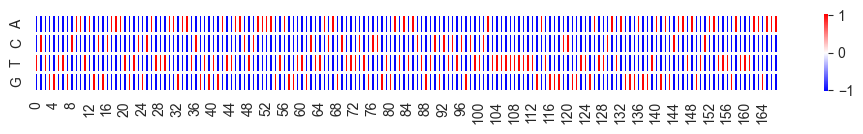

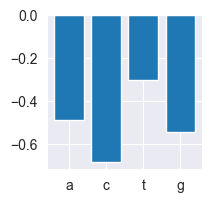

 Epoch 51 Loss: 0.00831441581249237
 Epoch 52 Loss: 0.021028000861406326
 Epoch 53 Loss: 0.024796534329652786
 Epoch 54 Loss: 0.03538091853260994
 Epoch 55 Loss: 0.028798189014196396
 Epoch 56 Loss: 0.03313584253191948
 Epoch 57 Loss: 0.045104604214429855
 Epoch 58 Loss: 0.030278796330094337
 Epoch 59 Loss: 0.027376405894756317
 Epoch 60 Loss: 0.028228318318724632
saving


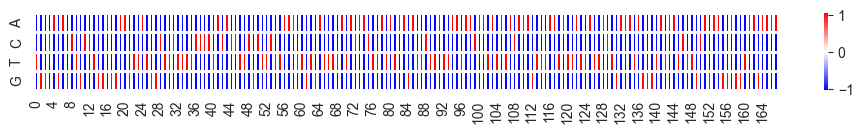

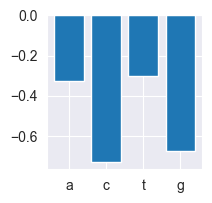

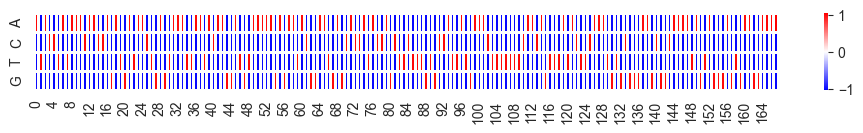

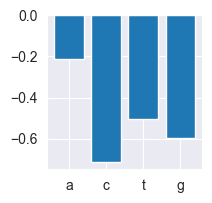

 Epoch 61 Loss: 0.039063915610313416
 Epoch 62 Loss: 0.014785503037273884
 Epoch 63 Loss: 0.01595965214073658
 Epoch 64 Loss: 0.014350706711411476
 Epoch 65 Loss: 0.02841251902282238
 Epoch 66 Loss: 0.026105847209692
 Epoch 67 Loss: 0.025254536420106888
 Epoch 68 Loss: 0.00980888120830059
 Epoch 69 Loss: 0.01689145714044571
 Epoch 70 Loss: 0.03748750686645508
saving


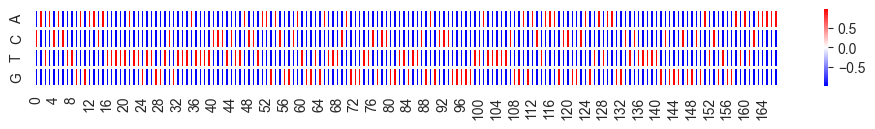

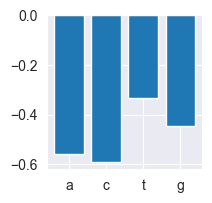

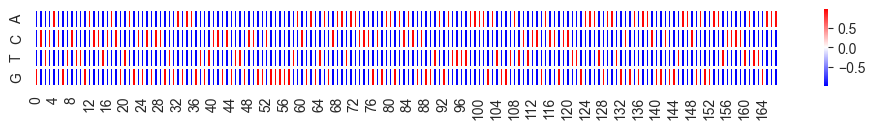

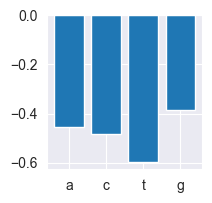

 Epoch 71 Loss: 0.030902361497282982
 Epoch 72 Loss: 0.02730105072259903
 Epoch 73 Loss: 0.02856026403605938
 Epoch 74 Loss: 0.028213495388627052
 Epoch 75 Loss: 0.05597900226712227
 Epoch 76 Loss: 0.03218241408467293
 Epoch 77 Loss: 0.05190170556306839
 Epoch 78 Loss: 0.02768258936703205
 Epoch 79 Loss: 0.009877335280179977
 Epoch 80 Loss: 0.04507191479206085
saving


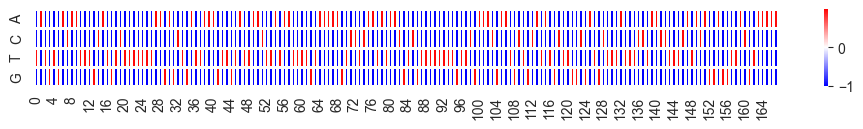

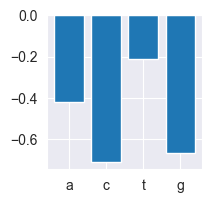

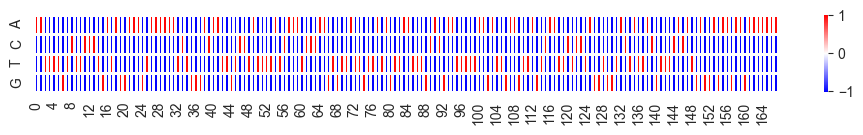

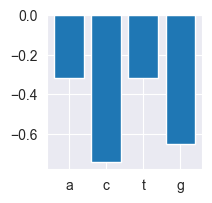

 Epoch 81 Loss: 0.034804243594408035
 Epoch 82 Loss: 0.05059073120355606
 Epoch 83 Loss: 0.043133947998285294
 Epoch 84 Loss: 0.025967705994844437
 Epoch 85 Loss: 0.018359145149588585
 Epoch 86 Loss: 0.03930679336190224
 Epoch 87 Loss: 0.03114764206111431
 Epoch 88 Loss: 0.0356384739279747
 Epoch 89 Loss: 0.0286102294921875
 Epoch 90 Loss: 0.04085760936141014
saving


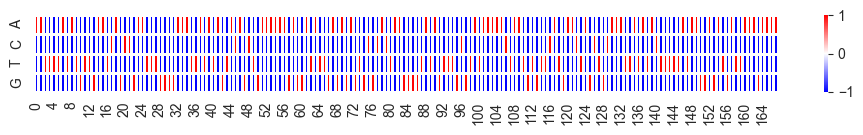

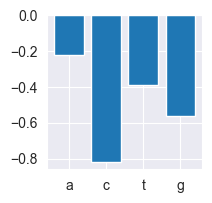

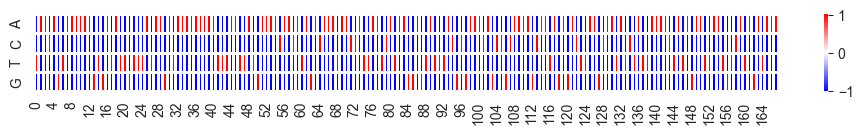

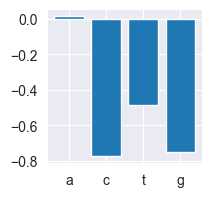

 Epoch 91 Loss: 0.02701662853360176
 Epoch 92 Loss: 0.03629656881093979
 Epoch 93 Loss: 0.04907285049557686
 Epoch 94 Loss: 0.0054753683507442474
 Epoch 95 Loss: 0.030550425872206688
 Epoch 96 Loss: 0.015007104724645615
 Epoch 97 Loss: 0.03722691163420677
 Epoch 98 Loss: 0.06201467663049698
 Epoch 99 Loss: 0.028447888791561127
 Epoch 100 Loss: 0.07569264620542526
saving


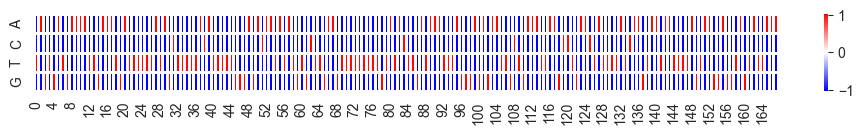

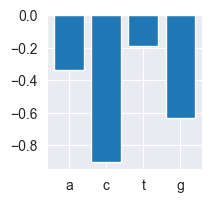

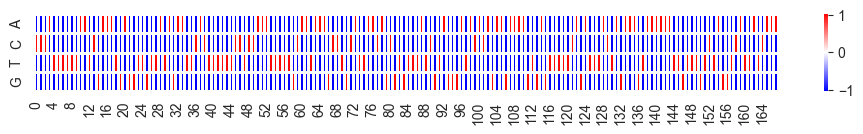

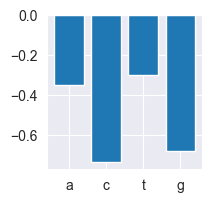

 Epoch 101 Loss: 0.01615830883383751
 Epoch 102 Loss: 0.04697254300117493
 Epoch 103 Loss: 0.01289864256978035
 Epoch 104 Loss: 0.04338796064257622
 Epoch 105 Loss: 0.04810410365462303
 Epoch 106 Loss: 0.026830114424228668
 Epoch 107 Loss: 0.018299676477909088
 Epoch 108 Loss: 0.02717745117843151
 Epoch 109 Loss: 0.01607624441385269
 Epoch 110 Loss: 0.040800318121910095
saving


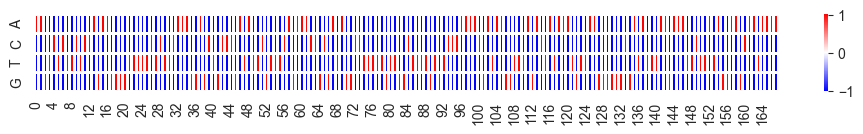

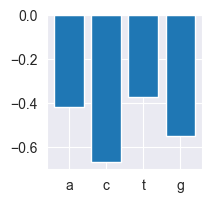

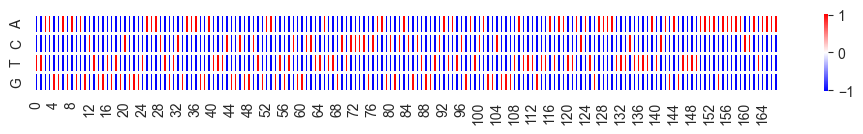

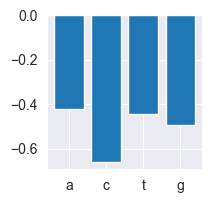

 Epoch 111 Loss: 0.013127134181559086
 Epoch 112 Loss: 0.04076308757066727
 Epoch 113 Loss: 0.012457674369215965
 Epoch 114 Loss: 0.03881257772445679
 Epoch 115 Loss: 0.062310900539159775
 Epoch 116 Loss: 0.017899762839078903
 Epoch 117 Loss: 0.03303031250834465
 Epoch 118 Loss: 0.026280509307980537
 Epoch 119 Loss: 0.018122153356671333


In [11]:
for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_dl):

        x = batch
        x = x.type(torch.float32).to(device)
        optimizer.zero_grad()
        # print (batch[0].dtype)
        # batch_size=64
        batch_size = x.shape[0]
        # batch_size = batch["pixel_values"].shape[0]
        # batch = batch["pixel_values"].to(device)
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()  # sampling a t to generate t and t+1
        # print (t.dtype)
        # loss = p_losses(model, batch, t, loss_type="l2")

        loss = p_losses(denoise_model=model, x_start=x, t=t,
                        sqrt_alphas_cumprod=sqrt_alphas_cumprod,
                        sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                        loss_type="huber")
        loss.backward()
        optimizer.step()

    if (epoch % epochs_loss_show) == 0:
        print(f" Epoch {epoch} Loss:", loss.item())

    torch.save(model.state_dict(), "model/{}/model_epoch_{}.pth".format(exper_name, epoch))

    # save generated images
    if epoch != 0 and epoch % save_and_sample_every == 0:
        print('saving')
        # sample(model, image_size, batch_size=16, channels=3)
        milestone = step // save_and_sample_every
        samples = sample(model, image_size=image_size, batch_size=2, channels=1, timesteps=timesteps, betas=betas,                         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                         sqrt_recip_alphas=sqrt_recip_alphas,
                         posterior_variance=posterior_variance)
        n_print = 0
        for image in samples[-1]:
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (12, 1)
                pd_seq = pd.DataFrame(image.reshape(4, seq_len))
                pd_seq.index = nucleotides
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
                plt.show()
                n_print = n_print + 1